# Intel oneAPI Default Risk Modelling Case Study

#### Importing package from python site packages

In [ ]:
!pip3 install imbalanced-learn
!pip3 install seaborn

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Data Collection from flat file using Pandas read_csv command

In [ ]:
#data=pd.read_csv(r'Add Your Dataset')
data=pd.read_csv(r'train.csv')

mydata is now a **DataFrame: Two-dimensional, size-mutable, potentially heterogeneous tabular data.**

Data structure also contains labeled axes (rows and columns). Arithmetic operations align on both row and column labels. Can be thought of as a dict-like container for Series objects. The primary pandas data structure.

You can also read excel file, json, text file & many more format in pandas just check out the documentation 
**Explore the data with head command, head give your 5 rows of the dataset**

In [ ]:
data.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-1984,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-1985,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-1985,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-1993,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-1977,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


**info()** function Print a concise summary of a DataFrame.

This method/function prints information about a DataFrame including the index dtype and column dtypes, non-null values and memory usage.

In [ ]:
data.info()

#### Lets look at all the unique values in the data

In [ ]:
for i in data.columns:
    print(i," : distinct_value")
    print(data[i].nunique()," : No. of unique Items")
    print(data[i].unique())
    print("-"*30)
    print("")

UniqueID  : distinct_value
233154  : No. of unique Items
[420825 537409 417566 ... 613658 548084 630213]
------------------------------

disbursed_amount  : distinct_value
24565  : No. of unique Items
[50578 47145 53278 ... 61456 51406 34259]
------------------------------

asset_cost  : distinct_value
46252  : No. of unique Items
[ 58400  65550  61360 ...  45233  52965 116009]
------------------------------

ltv  : distinct_value
6579  : No. of unique Items
[89.55 73.23 89.63 ... 33.32 32.53 33.82]
------------------------------

branch_id  : distinct_value
82  : No. of unique Items
[ 67  78  34 130  74  11   5  20  63  48  79   3  42 142  36  16 146 147
  65   9   1 152  29  10  70  19   7  85  61  17   8 153  18 162  68  72
  64   2 160 251 103 104 120 136  77  13 138 135  73 248  15 165  62  76
 105 249 250 255 254  82 158 159 117 202 259 207  35  69  97  43 257 258
 260 111  66 261 101  14 121 217  84 100]
------------------------------

supplier_id  : distinct_value
2953  : No. o

## Step 2: Data Transformation & Check for Missing Values

#Let check for missing values with pandas and we found Employment Type data is missing

if you look at your **Date.of.Birth** its a string, lets change it datetime format
mydata['Date.of.Birth'] 

In [ ]:
data.isna()

In [ ]:
round(100*(data.isna().sum())/len(data), 2)

UniqueID                               0.00
disbursed_amount                       0.00
asset_cost                             0.00
ltv                                    0.00
branch_id                              0.00
supplier_id                            0.00
manufacturer_id                        0.00
Current_pincode_ID                     0.00
Date.of.Birth                          0.00
Employment.Type                        3.29
DisbursalDate                          0.00
State_ID                               0.00
Employee_code_ID                       0.00
MobileNo_Avl_Flag                      0.00
Aadhar_flag                            0.00
PAN_flag                               0.00
VoterID_flag                           0.00
Driving_flag                           0.00
Passport_flag                          0.00
PERFORM_CNS.SCORE                      0.00
PERFORM_CNS.SCORE.DESCRIPTION          0.00
PRI.NO.OF.ACCTS                        0.00
PRI.ACTIVE.ACCTS                

Now we have 2 Columns named "AVERAGE_ACCT_AGE" & "CREDIT_HISTORY_LENGTH".
They have AplhNumeric Values Lets change them to Months

In [ ]:
def change_col_month(col):
    year = int(col.split()[0].replace('yrs',''))
    month = int(col.split()[1].replace('mon',''))
    return year*12+month

data['CREDIT.HISTORY.LENGTH'] = data['CREDIT.HISTORY.LENGTH'].apply(change_col_month)
data['AVERAGE.ACCT.AGE'] = data['AVERAGE.ACCT.AGE'].apply(change_col_month)

### Transform CNS Score And Create New Columns

In [ ]:
data['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts()

No Bureau History Available                                116950
C-Very Low Risk                                             16045
A-Very Low Risk                                             14124
D-Very Low Risk                                             11358
B-Very Low Risk                                              9201
M-Very High Risk                                             8776
F-Low Risk                                                   8485
K-High Risk                                                  8277
H-Medium Risk                                                6855
E-Low Risk                                                   5821
I-Medium Risk                                                5557
G-Low Risk                                                   3988
Not Scored: Sufficient History Not Available                 3765
J-High Risk                                                  3748
Not Scored: Not Enough Info available on the customer        3672
Not Scored

In [ ]:
def replace_scored(n):
    score=n.split("-")
    
    if len(score)!=1:
       
        return score[0]
    else:
        return 'N'
data['CNS_SCORE_DESCRIPTION']=data['PERFORM_CNS.SCORE.DESCRIPTION'].apply(replace_scored).astype(np.object)

/home/u52972/tmp/ipykernel_3986812/2530144808.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data['CNS_SCORE_DESCRIPTION']=data['PERFORM_CNS.SCORE.DESCRIPTION'].apply(replace_scored).astype(np.object)


Now Transform CNS Score Description data into Numbers

In [ ]:
sub_risk = {'N':-1, 'K':0, 'J':1, 'I':1, 'H':2, 'G':2, 'E':3,'F':3, 'L':7, 'M':7, 'B':7, 'D':7, 'A':7, 'C':7}

data['CNS_SCORE_DESCRIPTION']= data['CNS_SCORE_DESCRIPTION'].replace(sub_risk)

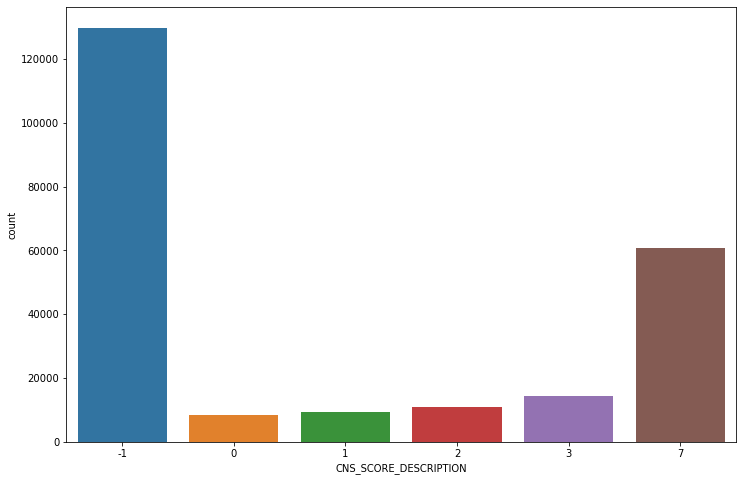

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x=data['CNS_SCORE_DESCRIPTION'])

Replacing all the values into Common Group

In [ ]:
data['PERFORM_CNS.SCORE.DESCRIPTION'].replace({'C-Very Low Risk':'Very Low Risk',
                                             'A-Very Low Risk':'Very Low Risk',
                                             'D-Very Low Risk':'Very Low Risk',
                                             'B-Very Low Risk':'Very Low Risk',
                                             'M-Very High Risk':'Very High Risk',
                                             'L-Very High Risk':'Very High Risk',
                                             'F-Low Risk':'Low Risk',
                                             'E-Low Risk':'Low Risk',
                                             'G-Low Risk':'Low Risk',
                                             'H-Medium Risk':'Medium Risk',
                                             'I-Medium Risk':'Medium Risk',
                                             'J-High Risk':'High Risk',
                                             'K-High Risk':'High Risk'},
                                              inplace=True)

Transformin them into Numeric Features

In [ ]:
risk_score = {'No Bureau History Available':-1, 
              'Not Scored: No Activity seen on the customer (Inactive)':-1,
              'Not Scored: Sufficient History Not Available':-1,
              'Not Scored: No Updates available in last 36 months':-1,
              'Not Scored: Only a Guarantor':-1,
              'Not Scored: More than 50 active Accounts found':-1,
              'Not Scored: Not Enough Info available on the customer':-1,
              'Very Low Risk':-1,
              'Low Risk':3,
              'Medium Risk':2, 
              'High Risk':1,
              'Very High Risk':0}

data['PERFORM_CNS.SCORE.DESCRIPTION'] = data['PERFORM_CNS.SCORE.DESCRIPTION'].map(risk_score)

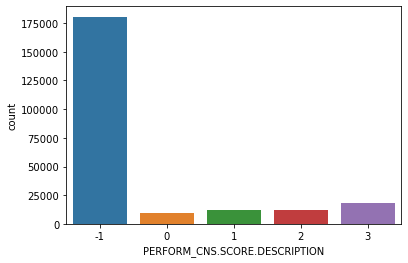

In [ ]:
sns.countplot(x=data['PERFORM_CNS.SCORE.DESCRIPTION'])

### Treating Missing Values

In [ ]:
data['Employment.Type'] = data['Employment.Type'].fillna(data['Employment.Type'].mode()[0])
data['Employment.Type'].value_counts()

Self employed    135296
Salaried          97858
Name: Employment.Type, dtype: int64

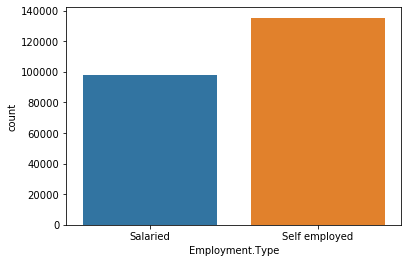

In [ ]:
sns.countplot(x=data['Employment.Type'])

In [ ]:
emp_map = {'Self employed':0, 'Salaried':1}

data['Employment.Type'] = data['Employment.Type'].replace(emp_map)

#### Transforming Primary and Secondary Accounts

In [ ]:
primary_col=['PRI.NO.OF.ACCTS','PRI.ACTIVE.ACCTS','PRI.OVERDUE.ACCTS','PRI.CURRENT.BALANCE',
             'PRI.SANCTIONED.AMOUNT','PRI.DISBURSED.AMOUNT','SEC.NO.OF.ACCTS','SEC.ACTIVE.ACCTS',
             'SEC.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.SANCTIONED.AMOUNT','SEC.DISBURSED.AMOUNT',
            'PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT']
pri_df = data[primary_col]

In [ ]:
#Creating and Sorting Columns

data['NO_OF_ACCTS'] = data['PRI.NO.OF.ACCTS'] + data['SEC.NO.OF.ACCTS']

data['ACTIVE_ACCTS'] = data['PRI.ACTIVE.ACCTS'] + data['SEC.ACTIVE.ACCTS']

data['OVERDUE_ACCTS'] = data['PRI.OVERDUE.ACCTS'] + data['SEC.OVERDUE.ACCTS']

data['CURRENT_BALANCE'] = data['PRI.CURRENT.BALANCE'] + data['SEC.CURRENT.BALANCE']

data['SANCTIONED_AMOUNT'] = data['PRI.SANCTIONED.AMOUNT'] + data['SEC.SANCTIONED.AMOUNT']

data['DISBURSED_AMOUNT'] = data['PRI.DISBURSED.AMOUNT'] + data['SEC.DISBURSED.AMOUNT']

data['INSTAL_AMT'] = data['PRIMARY.INSTAL.AMT'] + data['SEC.SANCTIONED.AMOUNT']

In [ ]:
data.drop(primary_col, axis=1, inplace=True)

In [ ]:
new_columns = ['NO_OF_ACCTS', 'ACTIVE_ACCTS', 'OVERDUE_ACCTS', 'CURRENT_BALANCE',
       'SANCTIONED_AMOUNT', 'DISBURSED_AMOUNT', 'INSTAL_AMT']

In [ ]:
for i in new_columns:
    print(i," : distinct_value")
    print(data[i].nunique()," : No. of unique Items")
    print(data[i].unique())
    print("-"*30)
    print("")

NO_OF_ACCTS  : distinct_value
108  : No. of unique Items
[  0   1   3   2   7  10   5   6  13   9   4  11  36   8  17  12  14  16
  24  30  21  15  34  25  56  20  49  19  45  18  23  22  31  46  26  40
  37  27  55  32  29  38  35  28  48  58  41  90  60  93  50  43  39  33
  44  66  53  52 120  47  42  62  82  94  51 108  57  67  78  54  68  65
  59 148 271  70  72  74  63 147  64  71  87  84  99  61  77 453 132  91
  81 113  69 194  76  73 354  97 105 102 136 124  85 131 104 114  86  83]
------------------------------

ACTIVE_ACCTS  : distinct_value
41  : No. of unique Items
[  0   1   2   5   4   8   3   6   9  11   7  12  10  14  21  31  16  18
  13  19  15  17  25  28  23  27  20  26  65  32  24  22  35  34  52  43
  37  36 144  42  39]
------------------------------

OVERDUE_ACCTS  : distinct_value
22  : No. of unique Items
[ 0  1  3  2 14  4  5 10  7  8  6  9 13 18 11 12 17 23 19 15 16 25]
------------------------------

CURRENT_BALANCE  : distinct_value
72483  : No. of unique 

# Visualization and Treating Outliers

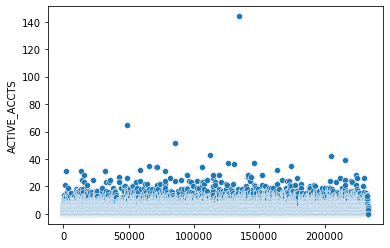

In [ ]:
sns.scatterplot(data=data['ACTIVE_ACCTS'])

In [ ]:
li = list(data['ACTIVE_ACCTS'].sort_values()[-5:].index)
data['ACTIVE_ACCTS'][li] = int(data.drop(li)['ACTIVE_ACCTS'].mode())

/home/u52972/tmp/ipykernel_3986812/2509761119.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ACTIVE_ACCTS'][li] = int(data.drop(li)['ACTIVE_ACCTS'].mode())


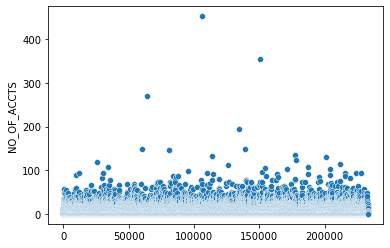

In [ ]:
sns.scatterplot(data=data['NO_OF_ACCTS'])

In [ ]:
li = list(data['NO_OF_ACCTS'].sort_values()[-10:].index)
data['NO_OF_ACCTS'][li] = int(data.drop(li)['NO_OF_ACCTS'].mode())

/home/u52972/tmp/ipykernel_3986812/3506611780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NO_OF_ACCTS'][li] = int(data.drop(li)['NO_OF_ACCTS'].mode())


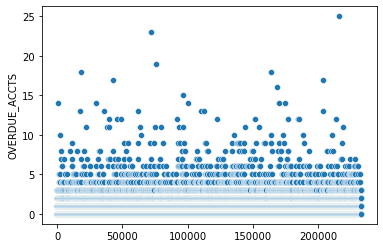

In [ ]:
sns.scatterplot(data=data['OVERDUE_ACCTS'])

In [ ]:
li = list(data['OVERDUE_ACCTS'].sort_values()[-10:].index)
data['OVERDUE_ACCTS'][li] = int(data.drop(li)['OVERDUE_ACCTS'].mode())

/home/u52972/tmp/ipykernel_3986812/1133309274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['OVERDUE_ACCTS'][li] = int(data.drop(li)['OVERDUE_ACCTS'].mode())


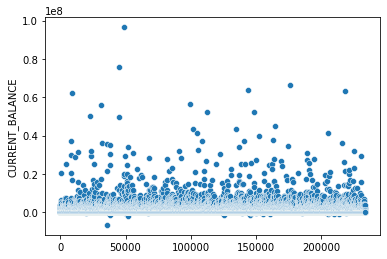

In [ ]:
sns.scatterplot(data = data['CURRENT_BALANCE'])

In [ ]:
df_age = data[['disbursed_amount', 'asset_cost', 'ltv', 'Date.of.Birth','DisbursalDate','loan_default']]

In [ ]:
def age(dob):
    yr = int(dob[-2:])
    if yr >=0 and yr < 22:
        return yr + 2000
    else:
         return yr + 1900
        
df_age['Date.of.Birth'] = df_age['Date.of.Birth'].apply(age)
df_age['DisbursalDate'] = df_age['DisbursalDate'].apply(age)
df_age['Age']=df_age['DisbursalDate']-df_age['Date.of.Birth']
df_age=df_age.drop(['DisbursalDate','Date.of.Birth'],axis=1)

df_age.head()

/home/u52972/tmp/ipykernel_3986812/3966675157.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age['Date.of.Birth'] = df_age['Date.of.Birth'].apply(age)
/home/u52972/tmp/ipykernel_3986812/3966675157.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age['DisbursalDate'] = df_age['DisbursalDate'].apply(age)
/home/u52972/tmp/ipykernel_3986812/3966675157.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

,disbursed_amount,asset_cost,ltv,loan_default,Age
0,50578,58400,89.55,0,34
1,47145,65550,73.23,1,33
2,53278,61360,89.63,0,33
3,57513,66113,88.48,1,25
4,52378,60300,88.39,1,41


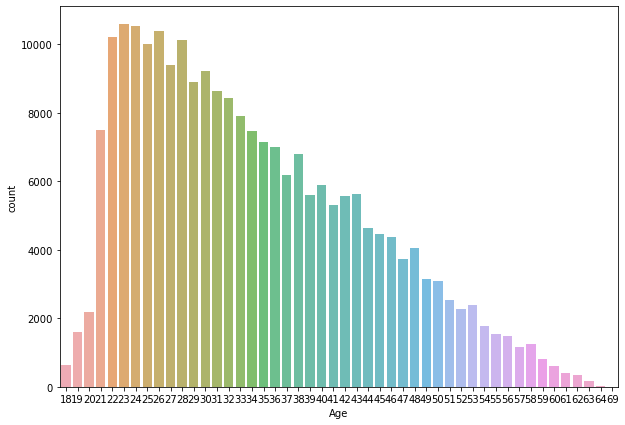

In [ ]:
ax = plt.subplots(figsize=(10,7))
sns.countplot(x=df_age['Age'],alpha=.8)

In [ ]:
data['Date.of.Birth'] = data['Date.of.Birth'].apply(age)
data['DisbursalDate'] = data['DisbursalDate'].apply(age)
data['Age'] = data['DisbursalDate'] - data['Date.of.Birth']
data = data.drop( ['DisbursalDate', 'Date.of.Birth'], axis=1)

In [ ]:
data_copy = data.copy()

In [ ]:
data['loan_default'].value_counts()/data.shape[0]

0    0.782929
1    0.217071
Name: loan_default, dtype: float64

In [ ]:
X = data_copy.drop(['loan_default'], axis=1)
y = data_copy['loan_default']

### Balance Data using SMOTE

In [ ]:
smote = SMOTE()

In [ ]:
X_tf,y_tf = smote.fit_resample(X,y)

In [ ]:
X_tf.shape, y_tf.shape

((365086, 33), (365086,))

## Transforming Data

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.RobustScaler()
X_tf = scaler.fit_transform(X_tf)

In [ ]:
# Split the data into training and testing sets 
x_train,x_test,y_train,y_test = train_test_split(X_tf,y_tf,test_size=.2, random_state = 3300)

Lets Start using Logistics Regression 

In [ ]:
lr = LogisticRegression(C=1.0,max_iter=2000)

In [ ]:
accuracy = {}
roc_r = {}

def train_model(model):
    # Checking accuracy
    model = model.fit(x_train, y_train)
    pred = model.predict(x_test)
    acc = accuracy_score(y_test, pred)*100
    accuracy[model] = acc
    print('accuracy_score',acc)
    print('precision_score',precision_score(y_test, pred)*100)
    print('recall_score',recall_score(y_test, pred)*100)
    print('f1_score',f1_score(y_test, pred)*100)
    roc_score = roc_auc_score(y_test, pred)*100
    roc_r[model] = roc_score
    print('roc_auc_score',roc_score)
    # confusion matrix
    print('confusion_matrix')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    fpr, tpr, threshold = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)*100

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

accuracy_score 66.90131200525897
precision_score 67.80035464085347
recall_score 64.0505286283125
f1_score 65.87211929507457
roc_auc_score 66.89399092126496
confusion_matrix
       0      1
0  25526  11077
1  13091  23324


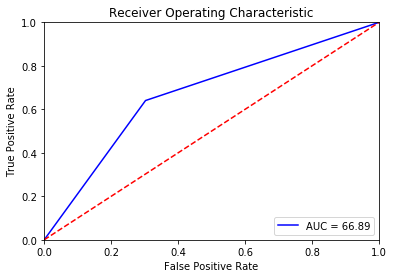

In [ ]:
train_model(lr)

In [ ]:
rfc = RandomForestClassifier(n_estimators=120,criterion='gini',n_jobs=-1)

accuracy_score 85.10367306691501
precision_score 92.49534078807243
recall_score 76.32294384182342
f1_score 83.63450340791118
roc_auc_score 85.08112331560613
confusion_matrix
       0      1
0  34348   2255
1   8622  27793


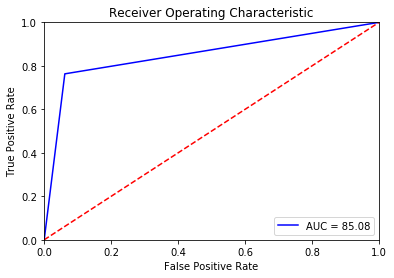

In [ ]:
train_model(rfc)

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

In [ ]:
train_model(xgb)

In [ ]:
#Run this when your free
criterion = ['gini','entropy']
n_estimators = [100, 200, 300, 500, 1000, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(criterion = criterion,
            n_estimators = n_estimators, max_depth = max_depth,  
            min_samples_split = min_samples_split, 
            min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(rfc, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(x_train, y_train)